<h1 style="color:rgb(0,120,170)">MLPC Assignment 3: Classification</h1>

<h3 style="color:rgb(0,120,170)">Context</h3>

Turning this into a machine learning problem entails:
1. splitting up the audio into small fragments, which will become the training examples,
2. computing a set of audio features for each fragment,
3. assigning a label to each fragment,
4. training a classifier to predict the label from the audio features.

<h3 style="color:rgb(0,120,170)">Context</h3>
Using the same training data as in Task 2, perform systematic classification experiments
in your team:

• Focus on predicting the presence or absence of the 6 bird species. Remember that
we made the simplifying assumption that these species will never be audible at
the same time, so for each audio fragment, there are exactly 7 options: either one
of the 6 species is audible, or none of them.

• Decide on an evaluation criterion to use. Mind that your goal is to correctly recognize all the birds.

• Apply at least least four different learning algorithms, from different major groups:
Support Vector Machines, Neural Networks, Nearest Neighbor Classifiers, Naive
Bayes, Decision Trees, Generalized Linear Models, Linear and Quadratic Discriminant Analysis. . . maybe also an “ensemble method” such as a Random Forest.

• For each algorithm, perform a systematic evaluation of different parameter settings, especially for those parameters that control the algorithm’s overfitting behavior. Analyse and document how the parameters affect whether overfitting
occurs (and to what extend it occurs), and how they affect classification performance.

• Use cross-validation for all your experiments. Decide how to split up the data
into folds, based on what you know about the data. Mind that your goal is to
estimate how your classifier will perform on unseen bird recordings.
For these experiments, you may use any machine learning package you want, such as
scikit-learn for Python, WEKA for Java, or builtin toolboxes for Matlab. You may want
to exploit that neither all the features nor all the training examples are equally useful.
Especially when working on (not-so-powerful) laptops, it can pay off to subsample the
training data to save computation time.

Document your results in a slide deck, touching each of the following aspects:

1. Data split: How was the cross-validation split done, and why?

2. Features: Which subset of features was selected or which preprocessing was applied, and why?

3. Evaluation: Which evaluation criterion did you choose to compare parameter
settings and algorithms? What is the baseline performance, what is the best we
can expect?
4. Experiments: For at least four different classifiers from the major groups given
above, vary the parameters, focusing on: (a) Does overfitting occur, to what extent, and what does it depend on? (b) How does classification performance change?
Include visualizations and/or tables to present your results. Compile a slide deck of
at most 20 slides (plus a title slide that includes your team name and member names).
Make sure to address all four aspects in your report.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import signal
import os
import glob

from sklearn.decomposition import PCA, FastICA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

import seaborn as sns


<h3 style="color:rgb(0,120,170)">1. Data Loading</h3>

In [6]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google'

<h3 style="color:rgb(0,120,170)">1.1. File Path</h3>

In [7]:
#1. Loading data
def get_all_files(directory_path):
    # Get a list of all the files in the directory
    file_names = os.listdir(directory_path)
    file_paths = [os.path.join(directory_path, file_name) for file_name in file_names if '.DS_Store' not in file_name]
    file_paths = [file_path for file_path in file_paths if os.path.isfile(file_path)]
    return file_paths

In [8]:
#2. Labeling (1 to six for target birds and 0 for no bird, e.g.)
root_dir = "/Users/luizhmadjarof/Documents/Universidade/(23:-) AI JKU Linz/SS 23 (1S)/MLPC MA/UB/A2/python"
feature_names = np.loadtxt("/Users/luizhmadjarof/Documents/Universidade/(23:-) AI JKU Linz/SS 23 (1S)/MLPC MA/UB/A2/python/feature_names.txt", dtype=str).T

dir_cowpig1 = root_dir + '/' + 'cowpig1'
dir_eueowl1= root_dir + '/' + 'eueowl1'
dir_tawowl1= root_dir + '/' + 'tawowl1'
dir_eucdov= root_dir + '/' + 'eucdov'
dir_grswoo= root_dir + '/' + 'grswoo'
dir_comcuc= root_dir + '/' + 'comcuc'

In [9]:
files_cowpig1= get_all_files(dir_cowpig1)
files_eueowl1= get_all_files(dir_eueowl1)
files_tawowl1= get_all_files(dir_tawowl1)
files_eucdov= get_all_files(dir_eucdov)
files_grswoo= get_all_files(dir_grswoo)
files_comcuc= get_all_files(dir_comcuc)

<h3 style="color:rgb(0,120,170)">1.2. Label Data Loading</h3>

In [10]:
all_cowpig1 = np.empty((0, 8))
all_eueowl1 = np.empty((0, 8))
all_tawowl1= np.empty((0, 8))
all_eucdov= np.empty((0, 8))
all_grswoo= np.empty((0, 8))
all_comcuc= np.empty((0, 8))

In [11]:
# Create an empty dictionary to store the label data
all_data = {}

# Loop through the files for each label
for label, files in {'cowpig1': files_cowpig1, 
                     'eueowl1': files_eueowl1, 
                     'tawowl1': files_tawowl1, 
                     'eucdov': files_eucdov, 
                     'grswoo': files_grswoo, 
                     'comcuc': files_comcuc}.items():
    # Initialize an empty list to store the individual data arrays for this label
    arrays = []
    
    # Loop through the files for this label
    for file in files:
        a,b = os.path.splitext(file)
        if a.endswith(".labels"):
            # Load the data array for this file
            array = np.load(file)
            # Append it to the list of arrays for this label
            arrays.append(array)
    
    # Determine the maximum number of columns across all arrays for this label
    max_columns = max(array.shape[1] for array in arrays)
    
    # Initialize an empty list to store the padded arrays for this label
    padded_arrays = []
    # Loop through each array for this label
    for array in arrays:
        # If the array has fewer columns than the maximum, pad it with zeros
        if array.shape[1] < max_columns:
            num_columns_to_add = max_columns - array.shape[1]
            padding = np.zeros((array.shape[0], num_columns_to_add))
            padded_array = np.concatenate((array, padding), axis=1)
            padded_arrays.append(padded_array)
        else:
            # Otherwise, append the array unchanged
            padded_arrays.append(array)
    
    # Concatenate the padded arrays along the first axis (rows) to create the final data array for this label
    all_data[label] = np.concatenate(padded_arrays, axis=0)

# Now you can access the final concatenated and padded data for each label using the dictionary
all_cowpig1 = all_data['cowpig1']
all_eueowl1 = all_data['eueowl1']
all_tawowl1 = all_data['tawowl1']
all_eucdov = all_data['eucdov']
all_grswoo = all_data['grswoo']
all_comcuc = all_data['comcuc']


In [12]:
all_files = np.concatenate((all_cowpig1, all_eueowl1, all_tawowl1, all_eucdov, all_grswoo, all_comcuc))

In [13]:
labels = pd.DataFrame(all_files)
labels

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
119995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3 style="color:rgb(0,120,170)">1.2. Feature Data Loading</h3>

In [14]:
#Feature data
all_fcowpig1 = np.empty((0, 548))
all_feueowl1 = np.empty((0, 548))
all_ftawowl1= np.empty((0, 548))
all_feucdov= np.empty((0, 548))
all_fgrswoo= np.empty((0, 548))
all_fcomcuc= np.empty((0, 548))

In [15]:
# Create an empty dictionary to store the label data
all_fdata = {}

# Loop through the files for each label
for label, files in {'cowpig1': files_cowpig1, 
                     'eueowl1': files_eueowl1, 
                     'tawowl1': files_tawowl1, 
                     'eucdov': files_eucdov, 
                     'grswoo': files_grswoo, 
                     'comcuc': files_comcuc}.items():
    # Initialize an empty list to store the individual data arrays for this label
    arrays = []
    
    # Loop through the files for this label
    for file in files:
        a,b = os.path.splitext(file)
        if not a.endswith(".labels"):
            # Load the data array for this file
            array = np.load(file)
            # Append it to the list of arrays for this label
            arrays.append(array)
    
    # Determine the maximum number of columns across all arrays for this label
    max_columns = max(array.shape[1] for array in arrays)
    
    # Initialize an empty list to store the padded arrays for this label
    padded_arrays = []
    # Loop through each array for this label
    for array in arrays:
        # If the array has fewer columns than the maximum, pad it with zeros
        if array.shape[1] < max_columns:
            num_columns_to_add = max_columns - array.shape[1]
            padding = np.zeros((array.shape[0], num_columns_to_add))
            padded_array = np.concatenate((array, padding), axis=1)
            padded_arrays.append(padded_array)
        else:
            # Otherwise, append the array unchanged
            padded_arrays.append(array)
    
    # Concatenate the padded arrays along the first axis (rows) to create the final data array for this label
    all_fdata[label] = np.concatenate(padded_arrays, axis=0)

# Now you can access the final concatenated and padded data for each label using the dictionary
all_fcowpig1 = all_fdata['cowpig1']
all_feueowl1 = all_fdata['eueowl1']
all_ftawowl1 = all_fdata['tawowl1']
all_feucdov = all_fdata['eucdov']
all_fgrswoo = all_fdata['grswoo']
all_fcomcuc = all_fdata['comcuc']

In [16]:
all_ffiles = np.concatenate((all_fcowpig1, all_feueowl1, all_ftawowl1, all_feucdov, all_fgrswoo, all_fcomcuc))

In [17]:
features = pd.DataFrame(all_ffiles, columns = feature_names)
features

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.104213,0.025389,144.178635,167.021698,115.430466,115.579773,124.897186,124.318657,134.522064,138.791565,...,12.657701,14.509855,18.643116,2.905979,2.252764,2.997747,3.173423,2.699984,2.714874,2.329038
1,0.108329,0.018797,116.932335,116.810623,104.958511,106.856224,107.122963,131.222122,353.585815,128.099060,...,13.057364,13.359251,16.425354,2.510432,2.361842,2.691745,1.427239,2.369561,1.818932,2.163963
2,0.203055,0.022426,319.182281,131.998932,131.480270,121.196114,121.224365,121.071152,131.966660,794.266663,...,12.970959,21.755045,21.717041,1.537123,1.638237,3.026752,1.810459,2.805019,4.571950,4.293758
3,0.119210,0.032156,256.728058,515.784363,224.581177,112.526237,131.550888,131.923523,129.934570,115.061554,...,14.145430,15.075860,19.178572,2.318594,2.508579,1.901502,3.409710,2.446294,1.661939,3.035185
4,0.113839,0.019690,116.983658,108.427589,108.570358,136.068344,135.782394,111.091484,111.612175,104.272835,...,12.054803,14.731396,17.400953,3.947008,1.956441,2.477308,3.416498,1.927335,1.812950,1.570067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0.073382,0.043350,858.709106,859.935059,863.328430,4302.474121,4084.642578,3813.006836,3866.472412,4184.843750,...,17.373228,16.825651,22.475708,2.356882,2.618949,2.250412,2.331108,4.017359,2.289333,2.304441
119996,0.026786,0.021679,3544.072021,3636.010010,3683.929199,3720.447510,3778.039062,3810.043457,3821.472656,3775.821533,...,13.843332,15.092970,19.419765,1.739386,1.899920,2.972288,3.275728,3.504961,1.926326,1.559724
119997,0.000837,0.003018,3488.506104,3421.704102,3381.033447,3309.861572,3363.148926,3329.871582,3270.464844,3205.298096,...,13.192764,14.612162,16.889723,2.074640,3.095009,2.575306,3.005124,2.567822,2.403719,0.977590
119998,0.000000,0.000000,2856.960938,2819.917480,2707.269775,5311.467773,2821.321533,2906.507568,2896.592285,2886.045166,...,13.242117,16.405230,17.726557,3.940534,3.248955,4.130877,1.688196,3.651503,3.851557,1.590729


<h3 style="color:rgb(0,120,170)">2. Feature Selection</h3>

In [296]:
features

,zcr_mean,zcr_std,yin_0,yin_1,yin_2,yin_3,yin_4,yin_5,yin_6,yin_7,...,cln_contrast_mean_4,cln_contrast_mean_5,cln_contrast_mean_6,cln_contrast_std_0,cln_contrast_std_1,cln_contrast_std_2,cln_contrast_std_3,cln_contrast_std_4,cln_contrast_std_5,cln_contrast_std_6
0,0.104213,0.025389,144.178635,167.021698,115.430466,115.579773,124.897186,124.318657,134.522064,138.791565,...,12.657701,14.509855,18.643116,2.905979,2.252764,2.997747,3.173423,2.699984,2.714874,2.329038
1,0.108329,0.018797,116.932335,116.810623,104.958511,106.856224,107.122963,131.222122,353.585815,128.099060,...,13.057364,13.359251,16.425354,2.510432,2.361842,2.691745,1.427239,2.369561,1.818932,2.163963
2,0.203055,0.022426,319.182281,131.998932,131.480270,121.196114,121.224365,121.071152,131.966660,794.266663,...,12.970959,21.755045,21.717041,1.537123,1.638237,3.026752,1.810459,2.805019,4.571950,4.293758
3,0.119210,0.032156,256.728058,515.784363,224.581177,112.526237,131.550888,131.923523,129.934570,115.061554,...,14.145430,15.075860,19.178572,2.318594,2.508579,1.901502,3.409710,2.446294,1.661939,3.035185
4,0.113839,0.019690,116.983658,108.427589,108.570358,136.068344,135.782394,111.091484,111.612175,104.272835,...,12.054803,14.731396,17.400953,3.947008,1.956441,2.477308,3.416498,1.927335,1.812950,1.570067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0.073382,0.043350,858.709106,859.935059,863.328430,4302.474121,4084.642578,3813.006836,3866.472412,4184.843750,...,17.373228,16.825651,22.475708,2.356882,2.618949,2.250412,2.331108,4.017359,2.289333,2.304441
119996,0.026786,0.021679,3544.072021,3636.010010,3683.929199,3720.447510,3778.039062,3810.043457,3821.472656,3775.821533,...,13.843332,15.092970,19.419765,1.739386,1.899920,2.972288,3.275728,3.504961,1.926326,1.559724
119997,0.000837,0.003018,3488.506104,3421.704102,3381.033447,3309.861572,3363.148926,3329.871582,3270.464844,3205.298096,...,13.192764,14.612162,16.889723,2.074640,3.095009,2.575306,3.005124,2.567822,2.403719,0.977590
119998,0.000000,0.000000,2856.960938,2819.917480,2707.269775,5311.467773,2821.321533,2906.507568,2896.592285,2886.045166,...,13.242117,16.405230,17.726557,3.940534,3.248955,4.130877,1.688196,3.651503,3.851557,1.590729


<h3 style="color:rgb(0,120,170)">2.2. Feature Selection</h3>

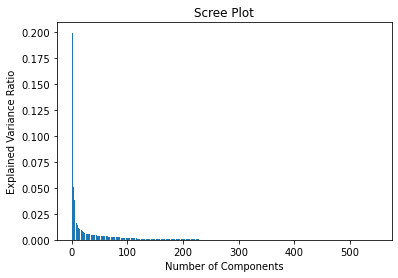

In [233]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(selected_features)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create the scree plot
component_numbers = np.arange(1, len(explained_variances) + 1)
plt.bar(component_numbers, explained_variances)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [227]:
sf2 = sf1.copy()
feature_corr = sf2.corr().abs()

upper_tri = feature_corr.where(np.triu(np.ones(feature_corr.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
sf2.drop(to_drop, axis=1, inplace=True)

sf2

,zcr_mean,zcr_std,yin_0,raw_melspect_mean_0,raw_melspect_std_4,raw_melspect_std_8,raw_melspect_std_13,raw_melspect_std_52,raw_mfcc_mean_0,raw_mfcc_mean_2,...,cln_mfcc_mean_0,cln_mfcc_mean_1,cln_mfcc_mean_2,cln_mfcc_mean_4,cln_mfcc_mean_5,cln_mfcc_mean_15,cln_mfcc_mean_17,cln_centroid_mean,cln_contrast_mean_0,cln_contrast_mean_1
zcr_mean,1.000000,0.457498,0.039588,-0.406481,-0.069462,-0.132583,-0.009747,0.251856,0.049904,-0.337260,...,0.032492,-0.334995,-0.115234,-0.101758,0.152715,-0.059877,-0.078351,0.155353,0.144840,-0.031695
zcr_std,0.457498,1.000000,0.102195,-0.104737,0.110815,0.139176,0.103763,0.449087,0.112943,-0.125048,...,0.071929,-0.262443,-0.010013,-0.125744,0.128377,-0.028595,-0.054313,0.089627,0.045560,0.002460
yin_0,0.039588,0.102195,1.000000,0.026276,-0.030007,-0.022899,0.017780,0.101970,-0.065101,0.064637,...,-0.095906,-0.142782,0.004591,-0.038984,0.094148,-0.026306,-0.033548,0.085164,-0.032167,0.047111
raw_melspect_mean_0,-0.406481,-0.104737,0.026276,1.000000,0.031475,0.026401,-0.061423,-0.075751,0.512624,0.424680,...,0.088795,0.074874,0.060768,0.043379,0.018687,0.039689,0.021386,0.009977,-0.036902,-0.030102
raw_melspect_std_4,-0.069462,0.110815,-0.030007,0.031475,1.000000,0.356758,0.302749,0.104577,-0.004862,0.097754,...,0.038399,0.143645,0.089852,0.036891,-0.010522,-0.030213,0.008594,-0.160002,0.039536,0.020924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cln_mfcc_mean_15,-0.059877,-0.028595,-0.026306,0.039689,-0.030213,0.138460,-0.052524,-0.057182,0.044172,0.016542,...,0.006900,0.067102,0.071580,-0.014395,-0.081079,1.000000,0.199448,-0.049818,0.016025,-0.005653
cln_mfcc_mean_17,-0.078351,-0.054313,-0.033548,0.021386,0.008594,0.020203,-0.013336,-0.083266,0.011198,0.024848,...,0.011750,0.094574,0.043199,-0.008647,-0.052780,0.199448,1.000000,-0.098434,0.021264,-0.006287
cln_centroid_mean,0.155353,0.089627,0.085164,0.009977,-0.160002,-0.275864,-0.243456,0.040240,-0.110770,0.127855,...,-0.341247,-0.490729,0.390870,0.180866,0.321316,-0.049818,-0.098434,1.000000,-0.038100,-0.080991
cln_contrast_mean_0,0.144840,0.045560,-0.032167,-0.036902,0.039536,-0.020225,0.004209,-0.009719,-0.021030,-0.013555,...,-0.085656,-0.004776,0.009972,0.001878,0.005456,0.016025,0.021264,-0.038100,1.000000,0.151593


<h3 style="color:rgb(0,120,170)">Eliminating High Inter-Features Correlation</h3>

In [234]:
# Copy of features
selected_features = features.copy()
# Compute correlation matrix of features
feature_corr = features.corr().abs()


In [235]:
# Taking the upper 65%
upper_tri = feature_corr.where(np.triu(np.ones(feature_corr.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.65)]
selected_features.drop(to_drop, axis=1, inplace=True)


In [243]:
selected_features

,zcr_mean,zcr_std,yin_0,raw_melspect_mean_0,raw_melspect_std_0,raw_mfcc_mean_1,raw_mfcc_mean_2,raw_mfcc_mean_3,raw_mfcc_mean_4,raw_mfcc_mean_5,...,cln_mfcc_mean_4,cln_mfcc_mean_5,cln_flatness_mean,cln_flatness_std,cln_centroid_mean,cln_flux_mean,cln_bandwidth_mean,cln_contrast_mean_0,cln_contrast_mean_1,cln_contrast_mean_2
0,0.104213,0.025389,144.178635,5.260280,0.678598,11.722803,-2.886116,1.625302,-0.766484,0.358663,...,-0.130756,0.165595,0.235257,0.102272,6887.078613,6.298171,2884.992676,5.941001,5.571944,8.220659
1,0.108329,0.018797,116.932335,6.485734,0.315136,13.808211,-5.056562,2.318141,-0.455920,0.028335,...,0.156415,-0.046879,0.403903,0.094919,5813.555176,9.268286,3186.814941,5.584007,6.089088,7.443485
2,0.203055,0.022426,319.182281,7.089341,0.363829,13.450143,-4.334423,3.202057,-1.927366,0.460847,...,-1.254867,0.380876,0.088798,0.067826,5557.483887,57.868095,2620.215820,4.375466,5.434949,7.736153
3,0.119210,0.032156,256.728058,7.198322,0.459935,13.438527,-5.172253,3.509893,-1.106580,1.211608,...,-0.415970,1.130988,0.262824,0.132288,5596.516113,31.806095,2747.145020,6.926789,6.850839,8.108602
4,0.113839,0.019690,116.983658,7.488858,0.297487,15.132287,-6.222596,2.101814,0.111821,0.178368,...,0.859586,0.031872,0.331669,0.045000,5342.882812,19.879534,3198.522461,6.698604,6.036443,7.433480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0.073382,0.043350,858.709106,5.594575,0.236835,4.621610,-2.240215,2.218656,-4.246311,-2.819625,...,-4.681545,-3.063332,0.068536,0.045667,4001.078125,182.219864,3285.902588,3.968847,6.502321,8.068604
119996,0.026786,0.021679,3544.072021,5.809918,0.225777,3.714819,-3.111917,3.491264,-2.134536,-2.273956,...,-2.555302,-2.513235,0.180928,0.058953,4488.748535,62.407768,3333.172852,4.305187,4.845993,8.952189
119997,0.000837,0.003018,3488.506104,5.712483,0.378321,2.558474,-2.490510,5.043571,-1.124422,-1.422877,...,-1.545844,-1.647332,0.328268,0.037066,4939.418457,21.312246,3299.661377,3.660138,6.617898,8.227812
119998,0.000000,0.000000,2856.960938,5.624564,0.352010,1.487618,-2.024539,4.984841,-1.077376,-0.411108,...,-1.506265,-0.645174,0.302483,0.040981,5235.270020,25.521641,3105.989258,4.346611,6.420346,8.649150


In [244]:
correlation_matrix = selected_features.corr().abs()

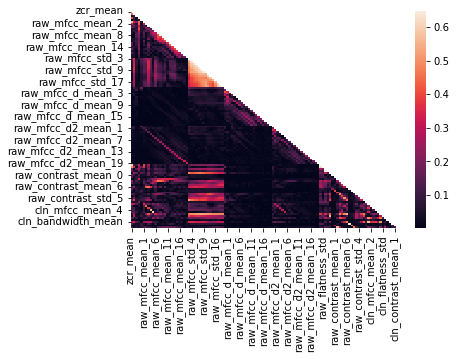

In [245]:
# Correlation heatmap after removing the high pair correlation features
mask = np.triu(np.ones_like(correlation_matrix))
dataplot = sns.heatmap(correlation_matrix, mask=mask)
 
# displaying heatmap
plt.show()

<h3 style="color:rgb(0,120,170)">PCA Dimensionality Reduction</h3>

In [236]:
selected_features

,zcr_mean,zcr_std,yin_0,raw_melspect_mean_0,raw_melspect_std_0,raw_mfcc_mean_1,raw_mfcc_mean_2,raw_mfcc_mean_3,raw_mfcc_mean_4,raw_mfcc_mean_5,...,cln_mfcc_mean_4,cln_mfcc_mean_5,cln_flatness_mean,cln_flatness_std,cln_centroid_mean,cln_flux_mean,cln_bandwidth_mean,cln_contrast_mean_0,cln_contrast_mean_1,cln_contrast_mean_2
0,0.104213,0.025389,144.178635,5.260280,0.678598,11.722803,-2.886116,1.625302,-0.766484,0.358663,...,-0.130756,0.165595,0.235257,0.102272,6887.078613,6.298171,2884.992676,5.941001,5.571944,8.220659
1,0.108329,0.018797,116.932335,6.485734,0.315136,13.808211,-5.056562,2.318141,-0.455920,0.028335,...,0.156415,-0.046879,0.403903,0.094919,5813.555176,9.268286,3186.814941,5.584007,6.089088,7.443485
2,0.203055,0.022426,319.182281,7.089341,0.363829,13.450143,-4.334423,3.202057,-1.927366,0.460847,...,-1.254867,0.380876,0.088798,0.067826,5557.483887,57.868095,2620.215820,4.375466,5.434949,7.736153
3,0.119210,0.032156,256.728058,7.198322,0.459935,13.438527,-5.172253,3.509893,-1.106580,1.211608,...,-0.415970,1.130988,0.262824,0.132288,5596.516113,31.806095,2747.145020,6.926789,6.850839,8.108602
4,0.113839,0.019690,116.983658,7.488858,0.297487,15.132287,-6.222596,2.101814,0.111821,0.178368,...,0.859586,0.031872,0.331669,0.045000,5342.882812,19.879534,3198.522461,6.698604,6.036443,7.433480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0.073382,0.043350,858.709106,5.594575,0.236835,4.621610,-2.240215,2.218656,-4.246311,-2.819625,...,-4.681545,-3.063332,0.068536,0.045667,4001.078125,182.219864,3285.902588,3.968847,6.502321,8.068604
119996,0.026786,0.021679,3544.072021,5.809918,0.225777,3.714819,-3.111917,3.491264,-2.134536,-2.273956,...,-2.555302,-2.513235,0.180928,0.058953,4488.748535,62.407768,3333.172852,4.305187,4.845993,8.952189
119997,0.000837,0.003018,3488.506104,5.712483,0.378321,2.558474,-2.490510,5.043571,-1.124422,-1.422877,...,-1.545844,-1.647332,0.328268,0.037066,4939.418457,21.312246,3299.661377,3.660138,6.617898,8.227812
119998,0.000000,0.000000,2856.960938,5.624564,0.352010,1.487618,-2.024539,4.984841,-1.077376,-0.411108,...,-1.506265,-0.645174,0.302483,0.040981,5235.270020,25.521641,3105.989258,4.346611,6.420346,8.649150


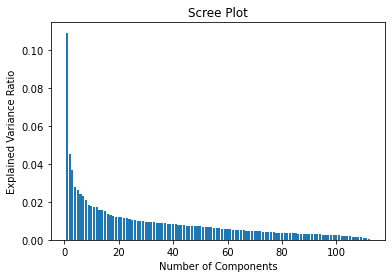

In [246]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(selected_features)

# Perform PCA on the scaled data
pca = PCA()
pca.fit(features_scaled)

# Get the explained variance ratios
explained_variances = pca.explained_variance_ratio_

# Create the scree plot
component_numbers = np.arange(1, len(explained_variances) + 1)
plt.bar(component_numbers, explained_variances)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

In [253]:
num_components = 80

# Calculate the cumulative explained variance up to the selected number of components
cumulative_variance = np.cumsum(explained_variances)[:num_components]

# Print the cumulative explained variance
print(f"Cumulative explained variance with {num_components} components: {cumulative_variance[-1]}")

Cumulative explained variance with 80 components: 0.9194094683605681


In [250]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Borrowed PCA analysis results from Abel
pca = PCA(n_components = 80)

features_pca = pca.fit_transform(features_scaled)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels.iloc[:, 0], test_size=0.2, random_state=42)

In [254]:
selected_features1 = pd.DataFrame(features_pca)
selected_features1

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,1.791994,3.303306,-0.246607,-0.375513,0.405586,1.033834,1.051862,-0.822095,4.353235,2.450005,...,-0.055442,-0.449363,0.304789,-0.188203,0.868141,0.380718,0.331418,0.718659,-1.198744,-1.385343
1,0.097101,1.781492,-1.007008,0.727873,1.325819,0.476383,-0.860520,0.237922,-0.973739,-0.128043,...,-0.576434,-0.160582,0.302548,-0.514086,-0.306393,0.045350,1.300630,0.601145,-0.077597,0.405348
2,6.219244,2.916082,-1.762921,0.174914,0.211064,0.105094,0.824574,-0.478362,1.308570,2.099804,...,-0.026012,-0.500549,0.654002,-0.962585,0.816004,0.129345,0.489542,0.566647,-0.036291,0.547426
3,2.018039,0.863435,-1.183302,-0.909812,1.518788,1.088019,-1.939883,0.270709,-1.363617,-1.718436,...,-0.974792,-0.324941,-0.076297,-0.603342,0.627985,-0.830068,1.648715,0.068747,-0.608866,1.715496
4,0.536368,0.197603,-1.544138,0.634512,1.611416,-1.689236,0.284575,0.396129,0.074410,-1.077665,...,0.814909,-0.258374,-0.836995,0.311952,-0.207761,-1.736649,-0.485814,-0.124139,-0.717673,0.717474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,6.933061,0.223553,0.581143,3.901134,-0.767832,-2.387336,1.327399,0.092358,-0.499150,1.285040,...,-1.007032,0.294635,0.890607,-0.581983,0.832344,1.621503,-0.344453,-0.412634,-0.993342,-2.612158
119996,4.288282,-1.342496,-0.756865,1.889423,-1.076122,-3.048436,-0.557106,0.130120,-0.900682,-0.725595,...,-0.216709,0.531755,0.774312,0.380048,-0.407169,1.562379,0.362743,-0.745699,-0.886617,-1.195036
119997,0.540718,-1.093760,-1.308527,1.710420,-0.140204,-1.786093,-0.897580,-2.366068,-1.233963,-0.139652,...,0.259619,0.129081,0.248048,0.496854,0.371112,-0.659888,-0.963302,1.541924,-0.466720,-0.624517
119998,3.679487,0.156296,-1.274762,1.025832,0.103076,-1.117082,1.307523,-1.713429,0.188170,0.920887,...,-0.310104,-0.471654,0.432249,-0.564854,0.690129,1.195555,-0.229659,-0.609314,-0.521974,0.428313


<h3 style="color:rgb(0,120,170)">Low Feature-Label Correlation Dimensionality Reduction</h3>


In [255]:
# Combine features_pca and labels
combined_data = pd.concat([selected_features1, labels], axis=1)

# Calculate correlation matrix
correlation_matrix = combined_data.corr()

# Filter the correlation matrix for correlations with labels
label_correlations = correlation_matrix.iloc[:-8, -8:]
label_correlations

,0,1,2,3,4,5,6,7
0,-0.011298,-0.011726,-0.012995,-0.016310,-0.017446,-0.007461,-0.004392,0.003491
1,0.010148,0.029310,0.024684,0.013365,0.008537,0.014405,0.007089,-0.021881
2,0.073404,0.085572,0.079991,0.066851,0.068402,0.084497,0.064565,0.038306
3,-0.000452,-0.011425,-0.009952,0.000451,-0.002836,-0.011905,-0.013502,-0.026167
4,-0.002387,-0.006452,-0.004037,-0.000473,-0.004615,-0.006617,-0.017067,-0.011390
...,...,...,...,...,...,...,...,...
75,-0.011600,-0.015438,-0.010265,-0.009187,-0.013764,-0.012778,-0.005238,-0.014093
76,0.003296,0.012277,0.005726,0.002248,0.001200,0.002186,0.012464,-0.001419
77,0.001984,0.002071,0.002715,0.003476,0.004582,0.006021,0.009349,-0.007145
78,-0.001047,0.002506,-0.006637,-0.001275,-0.004733,0.000755,0.001649,-0.008907


In [256]:
# Calculate the average correlation for each row
average_correlation = label_correlations.abs().mean(axis=1)
print(average_correlation)
# Filter rows with an average correlation below 0.7
selected_feat = label_correlations[average_correlation >= 0.01].index
print(selected_feat)

0     0.010640
1     0.016177
2     0.070198
3     0.009586
4     0.006630
        ...   
75    0.011545
76    0.005102
77    0.004668
78    0.003439
79    0.004820
Length: 80, dtype: float64
Int64Index([ 0,  1,  2,  5,  6,  7, 11, 12, 14, 16, 19, 20, 21, 22, 23, 24, 25,
            27, 45, 52, 55, 60, 71, 73, 75],
           dtype='int64')


In [257]:
min_corr = average_correlation.min()
max_corr = average_correlation.max()

print("Minimum average correlation:", min_corr)
print("Maximum average correlation:", max_corr)


Minimum average correlation: 0.0012229148386942669
Maximum average correlation: 0.0701984249362977


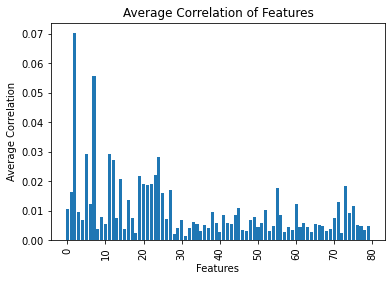

In [258]:
# Plot the average_correlation values
plt.bar(average_correlation.index, average_correlation.values)
plt.xlabel('Features')
plt.ylabel('Average Correlation')
plt.title('Average Correlation of Features')
plt.xticks(rotation=90)
plt.show()

In [259]:
above_threshold = average_correlation[average_correlation > 0.01]
count_above_threshold = len(above_threshold)
print("Number of values above 0.01: ", count_above_threshold)


Number of values above 0.01:  25


In [260]:
above_threshold = average_correlation[average_correlation > 0.01]
rows_above_threshold = above_threshold.index.tolist()
print("Rows with average correlation above 0.01:")
print(rows_above_threshold)


Rows with average correlation above 0.01:
[0, 1, 2, 5, 6, 7, 11, 12, 14, 16, 19, 20, 21, 22, 23, 24, 25, 27, 45, 52, 55, 60, 71, 73, 75]


In [262]:
sf = features_pca.loc[:, rows_above_threshold]

sf

,0,1,2,5,6,7,11,12,14,16,...,24,25,27,45,52,55,60,71,73,75
0,1.791994,3.303306,-0.246607,1.033834,1.051862,-0.822095,-1.564288,3.893851,-1.970771,-1.753192,...,1.243817,1.685532,-0.577811,1.307564,1.536135,1.131523,-1.121663,-0.449363,-0.188203,0.380718
1,0.097101,1.781492,-1.007008,0.476383,-0.860520,0.237922,0.011948,0.391437,-2.201391,-1.233196,...,1.523362,0.373167,-0.474670,0.626380,0.780064,0.940919,0.946058,-0.160582,-0.514086,0.045350
2,6.219244,2.916082,-1.762921,0.105094,0.824574,-0.478362,-1.952845,1.312541,-0.923542,0.801927,...,0.551180,-1.120841,1.259951,1.457078,-0.028447,-0.426747,-0.214212,-0.500549,-0.962585,0.129345
3,2.018039,0.863435,-1.183302,1.088019,-1.939883,0.270709,0.823084,-2.697592,-1.766388,-0.732310,...,0.023433,1.979430,-1.010571,-0.306624,0.225777,1.095818,0.084233,-0.324941,-0.603342,-0.830068
4,0.536368,0.197603,-1.544138,-1.689236,0.284575,0.396129,1.276209,0.722421,-2.394707,0.321576,...,0.350161,1.942544,-1.101885,1.349296,-0.199763,0.944104,-0.153682,-0.258374,0.311952,-1.736649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,6.933061,0.223553,0.581143,-2.387336,1.327399,0.092358,-1.086349,-2.972760,-2.036876,1.611542,...,0.344639,3.493837,-1.521361,1.758011,-2.685496,2.848763,1.328479,0.294635,-0.581983,1.621503
119996,4.288282,-1.342496,-0.756865,-3.048436,-0.557106,0.130120,0.525284,0.545878,-1.002240,0.912907,...,2.103725,-0.307448,0.220690,0.857474,-0.232843,0.518466,1.228551,0.531755,0.380048,1.562379
119997,0.540718,-1.093760,-1.308527,-1.786093,-0.897580,-2.366068,1.439508,0.350657,-1.043596,-0.301704,...,1.418113,-0.984991,1.137200,0.194888,0.645412,0.118288,2.641707,0.129081,0.496854,-0.659888
119998,3.679487,0.156296,-1.274762,-1.117082,1.307523,-1.713429,0.888465,0.114700,1.253176,-1.457275,...,1.261752,0.012643,-0.542243,-1.032002,0.572352,0.123144,-0.120796,-0.471654,-0.564854,1.195555


<h3 style="color:rgb(0,120,170)">3. Cross-Validation: Stratified K-Fold </h3>

In [291]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

<h3 style="color:rgb(0,120,170)">4. Models </h3>

<h3 style="color:rgb(0,120,170)">Method 1: Random Forest</h3>

In [284]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(sf, labels.iloc[:, 0], test_size=0.2, random_state=42)

# Train a Random Forest model on the training set
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: {:.2f}%".format(accuracy * 100))


Accuracy on test set: 71.15%


In [285]:
from sklearn.metrics import classification_report

# Generate predictions on the test set
y_pred = rfc.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.99      0.83     17056
         1.0       0.07      0.00      0.00      1148
         2.0       0.60      0.04      0.07      1881
         3.0       0.45      0.02      0.04      1578
         4.0       0.00      0.00      0.00       470
         5.0       0.85      0.02      0.05       979
         6.0       0.00      0.00      0.00       888

    accuracy                           0.71     24000
   macro avg       0.38      0.15      0.14     24000
weighted avg       0.62      0.71      0.60     24000



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [286]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation
scores = cross_val_score(rfc, sf, labels.iloc[:, 0], cv=5)

# Print the accuracy scores for each fold
for fold, score in enumerate(scores):
    print("Fold {}: {:.2f}%".format(fold+1, score * 100))

# Calculate and print the average accuracy
average_accuracy = scores.mean()
print("Average Accuracy: {:.2f}%".format(average_accuracy * 100))


Fold 1: 64.74%
Fold 2: 70.55%
Fold 3: 69.66%
Fold 4: 68.95%
Fold 5: 43.98%
Average Accuracy: 63.58%


In [298]:
for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train.values.ravel())
    
    y_pred = rfc.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    
    print("Classification Report:")
    print(report)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.99      0.83     17056
         1.0       0.22      0.00      0.01      1148
         2.0       0.61      0.04      0.07      1881
         3.0       0.42      0.02      0.04      1578
         4.0       0.00      0.00      0.00       470
         5.0       0.82      0.02      0.05       979
         6.0       0.00      0.00      0.00       888

    accuracy                           0.71     24000
   macro avg       0.40      0.15      0.14     24000
weighted avg       0.63      0.71      0.60     24000



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.99      0.83     17056
         1.0       0.00      0.00      0.00      1148
         2.0       0.59      0.03      0.06      1881
         3.0       0.40      0.02      0.04      1578
         4.0       0.00      0.00      0.00       470
         5.0       0.79      0.02      0.04       979
         6.0       0.00      0.00      0.00       888

    accuracy                           0.71     24000
   macro avg       0.36      0.15      0.14     24000
weighted avg       0.61      0.71      0.60     24000



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.99      0.83     17056
         1.0       0.21      0.00      0.01      1148
         2.0       0.60      0.03      0.06      1881
         3.0       0.46      0.02      0.04      1578
         4.0       0.00      0.00      0.00       470
         5.0       0.81      0.02      0.04       979
         6.0       0.00      0.00      0.00       888

    accuracy                           0.71     24000
   macro avg       0.40      0.15      0.14     24000
weighted avg       0.63      0.71      0.60     24000



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.99      0.83     17056
         1.0       0.11      0.00      0.00      1148
         2.0       0.58      0.04      0.07      1881
         3.0       0.43      0.02      0.04      1578
         4.0       0.00      0.00      0.00       470
         5.0       0.83      0.02      0.04       979
         6.0       0.00      0.00      0.00       888

    accuracy                           0.71     24000
   macro avg       0.38      0.15      0.14     24000
weighted avg       0.62      0.71      0.60     24000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.99      0.83     17056
         1.0       0.26      0.00      0.01      1148
         2.0       0.58      0.04      0.07      1881
         3.0       0.42      0.02      0.04      1578
         4.0       0.00      0.00      0.00       470
         5.0       0.87      0.0

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h3 style="color:rgb(0,120,170)">Method 2: Naive Bayes</h3>

In [301]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    y_pred = gnb.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    
    print("Classification Report:")
    print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.54      0.61     17056
         1.0       0.18      0.33      0.24      1148
         2.0       0.37      0.14      0.20      1881
         3.0       0.28      0.08      0.13      1578
         4.0       0.04      0.62      0.08       470
         5.0       0.13      0.08      0.10       979
         6.0       0.26      0.04      0.07       888

    accuracy                           0.43     24000
   macro avg       0.28      0.26      0.20     24000
weighted avg       0.56      0.43      0.47     24000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.54      0.61     17056
         1.0       0.18      0.33      0.24      1148
         2.0       0.37      0.14      0.20      1881
         3.0       0.28      0.08      0.13      1578
         4.0       0.04      0.62      0.08       470
         5.0       0.13      0.0

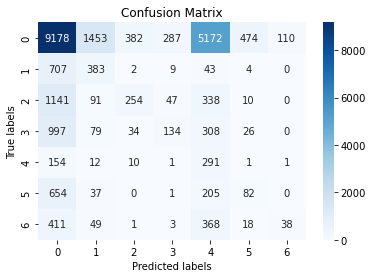

In [302]:
confusion_mat = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_mat.astype(int), annot=True, cmap='Blues', fmt='d')

# Add labels, title, and axis ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')


# Show the plot
plt.show()

<h3 style="color:rgb(0,120,170)">Method 3: Quadratic Discriminant Analysis (QDA)</h3>

In [214]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(sf, labels.iloc[:, 0], test_size=0.2, random_state=42)

# Train a QDA model on the training set
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = qda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: {:.2f}%".format(accuracy * 100))


Accuracy on test set: 24.38%


In [175]:
from sklearn.metrics import classification_report

# Generate predictions on the test set
y_pred = qda.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.09      0.16     17056
         1.0       0.26      0.75      0.39      1148
         2.0       0.23      0.61      0.33      1881
         3.0       0.28      0.34      0.31      1578
         4.0       0.05      0.73      0.09       470
         5.0       0.18      0.45      0.26       979
         6.0       0.17      0.37      0.23       888

    accuracy                           0.22     24000
   macro avg       0.27      0.48      0.25     24000
weighted avg       0.58      0.22      0.20     24000



In [176]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation
scores = cross_val_score(qda, sf, labels.iloc[:, 0], cv=5)

# Print the accuracy scores for each fold
for fold, score in enumerate(scores):
    print("Fold {}: {:.2f}%".format(fold+1, score * 100))

# Calculate and print the average accuracy
average_accuracy = scores.mean()
print("Average Accuracy: {:.2f}%".format(average_accuracy * 100))


Fold 1: 18.02%
Fold 2: 16.92%
Fold 3: 18.53%
Fold 4: 21.03%
Fold 5: 17.67%
Average Accuracy: 18.44%


<h3 style="color:rgb(0,120,170)">Method 4: KNN</h3>

In [293]:
for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train.values.ravel())
    
    y_pred = knn.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    
    print("Classification Report:")
    print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.90      0.80     17056
         1.0       0.28      0.17      0.21      1148
         2.0       0.41      0.19      0.26      1881
         3.0       0.30      0.12      0.17      1578
         4.0       0.10      0.02      0.03       470
         5.0       0.39      0.14      0.21       979
         6.0       0.24      0.08      0.12       888

    accuracy                           0.68     24000
   macro avg       0.35      0.23      0.26     24000
weighted avg       0.61      0.68      0.63     24000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.90      0.80     17056
         1.0       0.28      0.17      0.21      1148
         2.0       0.41      0.19      0.26      1881
         3.0       0.30      0.12      0.17      1578
         4.0       0.10      0.02      0.03       470
         5.0       0.39      0.1

<h3 style="color:rgb(0,120,170)">Method 5: Decision Tree Classifier</h3>

In [297]:
for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    dtc = DecisionTreeClassifier()
    dtc.fit(X_train, y_train.values.ravel())
    
    y_pred = dtc.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    
    print("Classification Report:")
    print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71     17056
         1.0       0.18      0.20      0.19      1148
         2.0       0.17      0.17      0.17      1881
         3.0       0.14      0.16      0.15      1578
         4.0       0.05      0.06      0.05       470
         5.0       0.12      0.13      0.12       979
         6.0       0.11      0.12      0.12       888

    accuracy                           0.54     24000
   macro avg       0.21      0.22      0.22     24000
weighted avg       0.55      0.54      0.55     24000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71     17056
         1.0       0.19      0.20      0.19      1148
         2.0       0.17      0.17      0.17      1881
         3.0       0.14      0.16      0.15      1578
         4.0       0.05      0.06      0.05       470
         5.0       0.11      0.1

<h3 style="color:rgb(0,120,170)">Variations of Random Forest</h3>

In [277]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sf, labels.iloc[:, 0], test_size=0.2, random_state=42)

# Further splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [278]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Creating a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Performing cross-validation on the training set
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)  # cv=5 specifies 5-fold cross-validation

# Average accuracy and standard deviation across folds
avg_accuracy = cv_scores.mean()
std_dev = cv_scores.std()

# Printing the results
print("Average Accuracy: {:.2f}%".format(avg_accuracy * 100))
print("Standard Deviation: {:.2f}%".format(std_dev * 100))


Average Accuracy: 71.26%
Standard Deviation: 0.09%


In [280]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Creating a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Training the classifier
rf_classifier.fit(X_train, y_train)

# Making predictions on the validation set
y_val_pred = rf_classifier.predict(X_val)

# Calculating accuracy on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Making predictions on the test set
y_test_pred = rf_classifier.predict(X_test)

# Calculating accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

# Printing the results
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))


Validation Accuracy: 71.23%


In [281]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    # Train and evaluate your model on each fold


In [282]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_fold, y_train_fold)

# Evaluate the classifier on the validation fold
accuracy = rf_classifier.score(X_val_fold, y_val_fold)


In [287]:
accuracy

0.7115

In [288]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
precisions = []
recalls = []
f1_scores = []
confusion_matrices = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the classifier
    rf_classifier.fit(X_train_fold, y_train_fold)
    
    # Predict the labels for the validation fold
    y_pred_fold = rf_classifier.predict(X_val_fold)
    
    # Compute evaluation metrics
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    precision = precision_score(y_val_fold, y_pred_fold, average=None)
    recall = recall_score(y_val_fold, y_pred_fold, average=None)
    f1 = f1_score(y_val_fold, y_pred_fold, average=None)
    confusion_matrix_fold = confusion_matrix(y_val_fold, y_pred_fold)
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_fold)

# Compute average metrics across all folds
avg_accuracy = sum(accuracies) / len(accuracies)
avg_precision = sum(precisions) / len(precisions)
avg_recall = sum(recalls) / len(recalls)
avg_f1 = sum(f1_scores) / len(f1_scores)

print("Performance Metrics:")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")

# Confusion matrix for the last fold
last_fold_confusion_matrix = confusion_matrices[-1]
print("Confusion Matrix (Last Fold):")
print(last_fold_confusion_matrix)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedM

Performance Metrics:
Average Accuracy: 0.7134
Average Precision: [0.71449755 0.27665446 0.59724666 0.54691515 0.         0.82527806
 0.        ]
Average Recall: [0.99474393 0.00213447 0.0400106  0.02069486 0.         0.02759061
 0.        ]
Average F1 Score: [0.8316462  0.00423149 0.07498089 0.03987179 0.         0.0533486
 0.        ]
Confusion Matrix (Last Fold):
[[13587    12    37    20     0     5     0]
 [  936     1     0     0     0     0     0]
 [ 1362     0    52     0     0     0     0]
 [ 1294     0     1    29     0     0     0]
 [  371     0     0     0     0     0     0]
 [  802     0     0     0     0    25     0]
 [  666     0     0     0     0     0     0]]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h3 style="color:rgb(0,120,170)">Inefficient Methods of Dimensionality Reduction</h3>

In [216]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize the estimator
estimator = RandomForestClassifier(random_state=42)

# Initialize RFE with 1 feature to eliminate at each step
selector = RFE(estimator, n_features_to_select=50, step=1)

# Fit selector to the PCA-transformed data
selector.fit(features, labels)

# Get the ranking of each feature
ranking = selector.ranking_

# Sort the features based on their ranking
sorted_features = sorted(zip(features.columns, ranking), key=lambda x: x[1])

# Select the top-k important features
k = 50  # Choose the desired number of features to keep
selected_features = [feat for feat, rank in sorted_features[:k]]


KeyboardInterrupt: 

In [84]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.feature_selection import SelectFromModel

# Scale the feature data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply MultiTaskLasso regularization with cross-validation
lasso = MultiTaskLassoCV(cv=5, random_state=42)  # Adjust the number of CV folds as needed
lasso.fit(features_scaled, labels)

# Select top 30 features based on Lasso coefficients
feature_selector = SelectFromModel(lasso, max_features=30)
selected_features = feature_selector.fit_transform(features_scaled, labels)

# Get the indices of the selected features
selected_feature_indices = feature_selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = features.columns[selected_feature_indices]

# Print the selected feature names
print("Selected Features:")
print(selected_feature_names)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299.2491455078125, tolerance: 231.80441284179688
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 358.0291442871094, tolerance: 231.80441284179688
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.6953430175781, tolerance: 231.80441284179688
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordina

KeyboardInterrupt: 

<h3 style="color:rgb(0,120,170)">Select K Best</h3>

In [66]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Select a subset of features using mutual information
selector = SelectKBest(mutual_info_classif, k=50)
X_selected = selector.fit_transform(features_pca, labels.iloc[:, 0])

# Perform k-fold cross-validation on the selected features
rfc = RandomForestClassifier()
scores = cross_val_score(rfc, X_selected, labels.iloc[:, 0], cv=5)

# Train the model on the selected features
rfc.fit(X_selected, labels.iloc[:, 0])


KeyboardInterrupt: 

In [60]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint

# Initialize the Random Forest classifier
rfc = RandomForestClassifier()


# Perform RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=10, cv=skf)
random_search.fit(X_train,  y_train.values.ravel())


KeyboardInterrupt: 

Total Variance Explained: 0.99997836


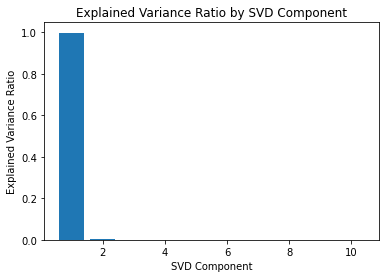

In [75]:
from sklearn.decomposition import TruncatedSVD

# Initialize the TruncatedSVD model
svd = TruncatedSVD(n_components=10, random_state=42)

# Fit and transform the features
features_svd = svd.fit_transform(features)

# Access the explained variance ratio
explained_variance_ratio = svd.explained_variance_ratio_

# Summarize the explained variance ratio
total_variance = np.sum(explained_variance_ratio)
print("Total Variance Explained:", total_variance)

# Plot the explained variance ratio
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('SVD Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by SVD Component')
plt.show()


In [ ]:
from sklearn.decomposition import KernelPCA

# Initialize the Kernel PCA model
kpca = KernelPCA(n_components=50, kernel='rbf', random_state=42)

# Fit and transform the features
features_kpca = kpca.fit_transform(features)

# Plot the reduced features
plt.scatter(features_kpca[:, 0], features_kpca[:, 1])
plt.xlabel('Kernel PCA Component 1')
plt.ylabel('Kernel PCA Component 2')
plt.title('Kernel PCA Dimensionality Reduction')
plt.show()


In [85]:
from sklearn.decomposition import FactorAnalysis

# instantiate the FA model with 10 components
fa = FactorAnalysis(n_components=10)

# fit the model to the data
features_fa = fa.fit_transform(features)

# calculate the log-likelihood
log_likelihood = fa.score(features)

print("Log-Likelihood:", log_likelihood)


Log-Likelihood: -121.60146832550492


In [ ]:
import umap.umap_ as umap

# Initialize the UMAP model
umap_model = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the features
features_umap = umap_model.fit_transform(features)

# Plot the reduced features
plt.scatter(features_umap[:, 0], features_umap[:, 1])
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Dimensionality Reduction')
plt.show()


In [ ]:
features_tsne

In [52]:
from sklearn.random_projection import GaussianRandomProjection

# Perform random projection to reduce the features to 50
random_projection = GaussianRandomProjection(n_components=50, random_state=42)
X_random_projected = random_projection.fit_transform(features_pca)

# X_random_projected now contains the reduced feature representation with 50 dimensions
ftrp =pd.DataFrame(X_random_projected)
ftrp

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,3.824011,4.989586,2.048109,-1.127897,-1.050444,-0.557161,3.819138,0.332511,6.478419,1.172503,...,-0.590977,0.499675,-2.526777,-2.307188,-5.563121,-0.073028,-3.118582,4.099513,-3.371219,-8.057709
1,0.561794,0.312246,-0.262711,2.155216,1.102023,-0.844087,0.207182,0.618179,-0.498371,-1.567220,...,-2.430059,-1.390435,-1.418179,-0.310671,-2.078168,-3.029981,-2.926148,-0.152486,-0.102661,-3.313775
2,2.733184,-0.684289,1.607968,0.487087,-0.471364,-4.204385,2.525116,-3.277972,1.256320,-0.596611,...,-4.169866,0.212812,-0.355254,2.025556,-2.555358,-3.815025,1.403534,2.717246,-0.392710,1.935458
3,-1.111943,0.644139,1.560726,-1.066398,1.699141,-1.524472,-4.174601,-0.095782,-0.392790,-1.409440,...,-1.599592,0.537150,-2.334193,-1.909743,-2.196267,-0.400964,-2.165187,0.568134,-1.048086,0.389139
4,-0.307290,0.419701,0.900344,-0.535825,2.727572,-0.149065,-0.368072,-2.783740,0.442479,0.465549,...,-1.259808,1.381557,1.277140,0.297213,-1.465069,-2.089872,-0.315943,-2.510521,-0.000818,-0.226698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,3.653260,-2.156365,2.658804,1.139102,0.853549,-2.962768,-1.945712,1.402711,3.270103,0.989202,...,-4.116643,1.950156,8.028561,-0.460359,0.571515,0.548930,-0.800388,-3.092847,-0.382364,2.298564
119996,0.409026,-2.087253,1.060917,0.591415,-0.375828,-1.589175,-1.542119,1.115580,1.413474,-0.747634,...,-1.519267,2.617866,3.054711,1.748132,-0.113744,-2.344463,-2.555214,-0.821668,0.027041,0.891881
119997,-1.594115,-2.686506,1.298713,-0.085870,2.343347,-3.725334,2.174742,-0.949613,-0.204778,0.852731,...,1.854642,1.677346,1.629484,0.244122,-1.888885,-1.632606,-0.970683,2.185915,1.454292,0.568093
119998,-0.967708,-1.417340,2.276247,-0.669891,-0.799794,-1.245764,0.741048,-2.051970,2.692668,-1.229536,...,-1.837498,1.678042,-1.379165,-0.304508,0.365879,-2.350777,-0.048141,1.396326,-1.112950,0.866010
